# **i implemented the last version of the paper, where i train the layer then i fine-tune all the network, over a bunch of SNRs**

# Documentation for `lcg-v8-16x64.ipynb`

This iPython notebook (`lcg-v8-16x64.ipynb`) details the implementation and evaluation of a communication system leveraging deep learning, specifically a Learned Conjugate Gradient (LCG) Network detector. The notebook employs a progressive training approach, where layers are added and fine-tuned iteratively. The LCG-Net's Bit Error Rate (BER) performance is then benchmarked against a classical Conjugate Gradient (CG) detector, a traditional Linear Minimum Mean Square Error (LMMSE) equalizer with channel estimation, and an ideal system with perfect Channel State Information (CSI).
![block systems](block%20systems.png)

## 1. Environment Setup and Imports

The initial section of the notebook sets up the necessary environment and imports.
- Sionna, a TensorFlow-based library for link-level simulations, is installed.
- TensorFlow is configured to utilize the GPU and manage memory growth for efficient computation.
- Essential libraries from TensorFlow, Keras, NumPy, Matplotlib, and Sionna are imported, which are crucial for constructing and simulating the communication system.

In [2]:
import os

# Optional: Set specific GPU (e.g., GPU 3); Kaggle typically gives you 1 GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0  # Only 1 GPU on Kaggle
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Hide TF logs

# Ensure TensorFlow and Sionna are installed
try:
    import sionna.phy
except ImportError:
    print("Installing Sionna...")
    !pip install -q sionna
    import importlib
    importlib.invalidate_caches()
    import sionna.phy

# TensorFlow GPU setup
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Avoid TensorFlow logging warnings
tf.get_logger().setLevel('ERROR')

# Set seed for reproducibility
sionna.phy.config.seed = 42
print("K")


Installing Sionna...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 9.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 64.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 93.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 MB 25.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 91.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 94.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.7/271.7 kB 17.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
ydata-profiling 4.16.1 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.3 which is incompatibl

E0000 00:00:1752974924.800192      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752974924.857300      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


K


I0000 00:00:1752974936.908381      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Available GPUs: {[gpu.name for gpu in gpus]}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Optional: restrict visible devices
        tf.config.set_visible_devices(gpus[0], 'GPU')  # use only first GPU
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found. Using CPU.")

Available GPUs: ['/physical_device:GPU:0']


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import Model, Layer
from tensorflow.keras.layers import Dense, LayerNormalization

import tempfile, shutil, pickle, glob, json

from sionna.phy.channel import RayleighBlockFading, OFDMChannel, FlatFadingChannel, KroneckerModel
from sionna.phy.mimo import StreamManagement, lmmse_equalizer
from sionna.phy.ofdm import ResourceGrid, ResourceGridMapper, RemoveNulledSubcarriers,ResourceGridDemapper, LSChannelEstimator, LMMSEEqualizer
from sionna.phy.utils import ebnodb2no, insert_dims, log10, expand_to_rank, sim_ber, PlotBER, compute_ser, compute_ber
from sionna.phy.mapping import Mapper, Demapper, SymbolDemapper,BinarySource, QAMSource
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
# from sionna.phy.channel.tr38901 import AntennaArray, CDL

**Massive MIMO, OFDM(10, 128), ANT(2, 128), SNR[15 ~ -5], Without outputLayer, alpha/beta vector**

## 2. System Parameters

Key parameters defining the Massive MIMO-OFDM system are outlined:
- `CARRIER_FREQUENCY`: 3.5 GHz
- `DELAY_SPREAD`: 300 ns
- `NUM_TX_ANT`: 16 (number of transmit antennas)
- `NUM_RX_ANT`: 64 (number of receive antennas)
- `NUM_TX`: 1 (number of User Equipments - UEs)
- `NUM_RX`: 1 (number of Base Stations - BS)
- `FFT_SIZE`: 64
- `NUM_OFDM_SYMBOLS`: 14
- `BITS_PER_SYMBOL`: 4 (representing 16-QAM modulation)
- `CODERATE`: 1/2
- `BATCH_SIZE`: 64
- A `StreamManagement` object and an `OFDMResourceGrid` are initialized.


In [5]:
CARRIER_FREQUENCY = 3.5e9  # Hz

DELAY_SPREAD = 300e-9  # s
NUM_TX_ANT = 16
NUM_RX_ANT = 64
NUM_TX = 1  # UEs
NUM_RX = 1  # BS
FFT_SIZE = 64
NUM_OFDM_SYMBOLS = 14
BITS_PER_SYMBOL = 4  # 16-QAM

STREAM_MANAGER = StreamManagement([[1]], num_streams_per_tx= NUM_TX_ANT)
CODERATE=1/2
BATCH_SIZE = 64

In [6]:
RESOURCE_GRID= ResourceGrid(
            num_ofdm_symbols=NUM_OFDM_SYMBOLS,
            fft_size = FFT_SIZE,
            subcarrier_spacing=30e3,
            num_tx = NUM_TX,
            num_streams_per_tx = NUM_TX_ANT,
            pilot_pattern="kronecker",
            pilot_ofdm_symbol_indices=[2, 8]
        )

## 3. Utility Functions

Several utility functions are defined to facilitate the detector's operations and performance measurement:
- `complex_to_real_matrix(H)`: Transforms a complex channel matrix `H` into an extended real-valued format, aligning with the paper's requirements for real-valued operations within the LCG-Net.
- `complex_to_real_vector(y)`: Converts a complex vector `y` (representing either the received signal or symbols) into its extended real-valued equivalent.
- `real_to_complex(x)`: Reverts an extended real-valued vector back to its complex form.
- `compute_A_b_effno(y, H, no)`: Calculates the `A` matrix ($\mathbf{H}^H\mathbf{H} + \sigma^2 \mathbf{I}$) and `b` vector ($\mathbf{H}^H\mathbf{y}$) essential for the Conjugate Gradient (CG) algorithm in the real-valued domain, alongside the effective noise variance.
- `nmse_fn(s, x_target)`: Computes the Normalized Mean Squared Error (NMSE) between the estimated and true symbols.

In [7]:
# @tf.function(jit_compile=True)
def complex_to_real_matrix(H):
    """Convertit la matrice complexe H en forme réelle étendue selon le papier.

    Args:
        H : [..., Nrx, Ntx], tf.complex64

    Returns:
        H_real : [..., 2*Nrx, 2*Ntx], tf.float32
    """
    H_real = tf.math.real(H)
    H_imag = tf.math.imag(H)

    # Construction de la matrice bloc [[R, -I], [I, R]]
    top = tf.concat([H_real, -H_imag], axis=-1)
    bottom = tf.concat([H_imag, H_real], axis=-1)
    H_real_expanded = tf.concat([top, bottom], axis=-2)

    return H_real_expanded

# @tf.function(jit_compile=True)
def complex_to_real_vector(y):
    """Convertit le vecteur complexe y en forme réelle étendue.

    Args:
        y : [..., Nrx], tf.complex64

    Returns:
        y_real : [..., 2*Nrx], tf.float32
    """
    return tf.concat([tf.math.real(y), tf.math.imag(y)], axis=-1)

In [8]:
# @tf.function(jit_compile=True)
def real_to_complex(x):
    """Convertit un vecteur réel étendu en complexe
    Args:
        y : [..., 2Ntx,1], tf.complex64

    Returns:
        y_complex : [..., Nrx, 1], tf.float32
    """
    x_real, x_imag = tf.split(x, 2, axis=-2)
    return tf.complex(x_real, x_imag)

In [9]:
# @tf.function(jit_compile=True)
def compute_A_b_effno(y, H, no):
    """noise_var shape: [batch_size]"""

    num_tx_ant = tf.shape(H)[-1]

    # Conversion en représentation réelle
    Hreal = complex_to_real_matrix(H)  # [batch_size, num_ofdm_symbols, fft_size, 2Nrx, 2Ntx]
    y_real = complex_to_real_vector(y)  # [batch_size, num_ofdm_symbols, fft_size, 2Nrx]

    # Calcul de Hᴴ (H_real^T dans cette représentation)
    Hherm= tf.transpose(Hreal, perm=[0, 1, 2, 4, 3])  # [batch_size, num_ofdm_symbols, fft_size, 2Ntx, 2Nrx]


    # A = HᴴH + σ²I
    Hherm_H = tf.matmul(Hherm, Hreal)  # [batch_size, num_ofdm_symbols, fft_size, 2Ntx, 2Ntx]

    # Ajout de σ²I
    I = tf.eye(2*num_tx_ant, batch_shape=[BATCH_SIZE, NUM_OFDM_SYMBOLS, FFT_SIZE], dtype=tf.float32) #[batch_size, num_ofdm_symbols, fft_size, 2Ntx, 2Ntx]
    sigma_no = no ** 2
    noise_I = sigma_no * I  #[batch, num_ofdm_symbols, fft_size, 2Ntx, 2Ntx]
    A = Hherm_H + noise_I   #[batch_size, num_ofdm_symbols, fft_size, 2Ntx, 2Ntx]

    # A_inv = tf.linalg.inv(A)
    # # Calcul de la matrice de bruit effective
    # eff_cov = tf.matmul(A_inv, noise_I)

    # # Step 1: Extract the diagonal of the real noise covariance matrix
    # diag_noise_real = tf.linalg.diag_part(eff_cov)  # shape: [batch_size, num_ofdm_symbols, fft_size, 2*Ntx]
    # # Step 2: Split into real and imag parts (alternate entries)
    # real_part = diag_noise_real[..., : num_tx_ant]        # corresponds to real(x) [batch_size, num_ofdm_symbols, fft_size, Ntx]
    # imag_part = diag_noise_real[..., num_tx_ant : ]        # corresponds to imag(x) [batch_size, num_ofdm_symbols, fft_size, Ntx]
    # # Step 3: Combine into effective noise (complex-domain)
    # eff_no = real_part + imag_part     # shape: [batch_size, num_ofdm_symbols, fft_size, Ntx]

    # b = Hᴴy
    b = tf.matmul(Hherm, tf.expand_dims(y_real, -1))  # [batch_size, num_ofdm_symbols, fft_size, 2Ntx, 1]

    return A, b, no

In [10]:
# @tf.function
def nmse_fn(s, x_target):
    mse = tf.reduce_mean(tf.square(s - x_target))
    denominator = tf.reduce_mean(tf.square(x_target))
    return mse / (denominator + 1e-12)

## 4. Detector Implementations

The notebook features implementations of different detectors:
- `LcgNetLayer(Layer)`: This class actualizes a single layer of the LCG-Net, performing Conjugate Gradient (CG) updates as described in equations (7)-(9) of the referenced paper, incorporating learnable $\alpha$ and $\beta$ parameters.
- `LcgNetDetector(Layer)`: This builds the complete LCG-Net by stacking multiple `LcgNetLayer` instances. It manages the initial real-valued transformation, the iterative updates through its layers, and the final conversion back to complex values. It supports a `max_layers` parameter to control its depth.
- `CGStep()`: Implements a single step of the traditional Conjugate Gradient (CG) algorithm, including the computation of $\alpha$ and $\beta$ based on residuals.
- `CGDetector()`: Realizes the classical CG detector by repeatedly applying `CGStep` until convergence or a predefined maximum number of iterations/layers is reached.

In [11]:
class LcgNetLayer(Layer):

    def __init__(self, i):
        super().__init__()
        self.i=i

        self.w_alpha = self.add_weight(
            shape=(1, NUM_OFDM_SYMBOLS, FFT_SIZE, 2*NUM_TX_ANT, 1),
            name=f"layer_{i}_\alpha",
            initializer=tf.constant_initializer(0.0),
            trainable=True)
        self.w_beta = self.add_weight(
            # shape=(batch_size, num_ofdm_symbols, fft_size, 2*NUM_TX_ANT,1),
            shape=(1, NUM_OFDM_SYMBOLS, FFT_SIZE, 2*NUM_TX_ANT, 1),
            name=f"layer_{i}_\beta",
            initializer=tf.constant_initializer(0.0),
            trainable=True)
        self.built= True
        # self.r= None

    # @tf.function(jit_compile=True)
    def call(self, s, r, d, A):

        # Calcul de α
        Ad = tf.matmul(A, d)
        alpha = self.w_alpha

        # Mise à jour de r
        r_new = r - alpha * Ad

        # Calcul de β
        beta  = self.w_beta

        # Mise à jour de x or (s)
        s_new = s + alpha * d

        # Mise à jour de d
        d_new = r_new + beta * d
        # self.r= r_new

        return s_new, r_new, d_new

In [12]:
class LcgNetDetector(Layer):
    def __init__(self, max_layers=50):
        super().__init__()
        self.max_layers = max_layers
        self.active_layers = []  # Couches effectivement utilisées
        self.pre_layers = []
        for i in range(1, max_layers+1):  # Proper layer registration
            layer = LcgNetLayer(i)
            self.pre_layers.append(layer)
            setattr(self, f"layer_{i}", layer)  # Pré-création

    # @tf.function
    def call(self, y, H, no, evaluate= False):
        A, b, no_eff = compute_A_b_effno(y, H, no)
        # Initialisation CG
        s = tf.zeros_like(b)  # (batch * (n / num_bits_per_symbol), 2Nt ,1)
        r = b   # (batch * (n / num_bits_per_symbol), 2Ntx ,1)
        d = r   # (batch * (n / num_bits_per_symbol), 2Ntx ,1)
        s_per_layer = []  # Optionally compute NMSE here
        
        for i, layer in enumerate(self.active_layers):
            if evaluate:
                s_complex = real_to_complex(s) # [batch_size, num_ofdm_symbols, fft_size, Ntx, 1]
                x_rg_hat = tf.transpose(s_complex, [0, 4, 3, 1, 2])
                s_per_layer.append(x_rg_hat)
            s, r, d = layer(s, r, d, A)                
            
        s_complex = real_to_complex(s) # [batch_size, num_ofdm_symbols, fft_size, Ntx, 1]
        s_hat_out= tf.squeeze(s_complex, axis=-1)   # [batch_size, num_ofdm_symbols, fft_size, Ntx]

        return s_hat_out, no_eff, s_per_layer

In [13]:
class CGStep():

    def __init__(self, i):
        self.i=i

    # @tf.function(jit_compile=True)
    def call(self, s, r, d, A):

        # Calcul de α
        Ad = tf.matmul(A, d)

        rTr = tf.reduce_sum(r * r, axis=[-2, -1], keepdims=True)       # [B, S, F, 1, 1]
        dTAd = tf.reduce_sum(d * Ad, axis=[-2, -1], keepdims=True)     # [B, S, F, 1, 1]
        alpha = rTr / (dTAd + 1e-8)   

        # Mise à jour de r
        r_new = r - alpha * Ad

        # Calcul de β
        rTr_new = tf.reduce_sum(r_new * r_new, axis=[-2, -1], keepdims=True)
        beta = rTr_new / (rTr + 1e-8)

        # Mise à jour de x or (s)
        s_new = s + alpha * d

        # Mise à jour de d
        d_new = r_new + beta * d

        return s_new, r_new, d_new

In [14]:
class CGDetector():
    
    def __init__(self, max_layers=50):
        self.max_layers = max_layers
        self.active_layers = []  # Couches effectivement utilisées
        for i in range(1, max_layers+1):  # Proper layer registration
            layer = CGStep(i)
            self.active_layers.append(layer)
            setattr(self, f"layer_{i}", layer)  # Pré-création

    # @tf.function(jit_compile=True)
    def call(self, y, H, no, evaluate = False):
        A, b, no_eff = compute_A_b_effno(y, H, no)
        # Initialisation CG
        s = tf.zeros_like(b)  # (batch * (n / num_bits_per_symbol), 2Nt ,1)
        r = b   # (batch * (n / num_bits_per_symbol), 2Ntx ,1)
        d = r   # (batch * (n / num_bits_per_symbol), 2Ntx ,1)
        s_per_layer = []
        
        for i, step in enumerate(self.active_layers):
            if evaluate:
                s_complex = real_to_complex(s) # [batch_size, num_ofdm_symbols, fft_size, Ntx, 1]
                x_rg_hat = tf.transpose(s_complex, [0, 4, 3, 1, 2])
                s_per_layer.append(x_rg_hat)
            s_new, r, d = step.call(s, r, d, A)
            r_norm = tf.norm(r, ord='euclidean', axis=[-2, -1])  # shape [B, S, F]
            rel_r = tf.norm(r) / (tf.norm(b) + 1e-8)
            
            delta_s = tf.norm(s_new - s, ord='euclidean', axis=[-2, -1])
            if tf.reduce_all((rel_r < 1e-6) & (delta_s < 1e-9)):
                break
            s= s_new

        s_complex = real_to_complex(s) # [batch_size, num_ofdm_symbols, fft_size, Ntx, 1]
        s_hat_out= tf.squeeze(s_complex, axis=-1)   # [batch_size, num_ofdm_symbols, fft_size, Ntx]

        return s_hat_out, no_eff, s_per_layer

## 5. Progressive Trainer

The `ProgressiveTrainer` is a custom class designed to systematically train the `LcgNetDetector`:
- It iteratively adds layers to the network.
- It trains each newly added layer (Phase 1) using various learning rates, including base and refinement stages.
- After training a new layer, it fine-tunes all currently active layers (Phase 2).
- The trainer saves and restores the best weights and training progress to JSON and PKL files, ensuring data persistence.
- NMSE is monitored for convergence and to enable early stopping mechanisms.

In [15]:
class ProgressiveTrainer:
    def __init__(self, system, validation_batch_size=128):
        self.system = system
        self.validation_batch_size = BATCH_SIZE
        self.snr_levels = [15.0, 10.0, 5.0, 0.0]
        self.refinement_rates = [0.5, 0.1, 0.05, 0.001]
        self.refinement_epochs = [0.8, 0.5, 0.2, 0.1]
        self.base_epochs= 50
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.best_weights = {}
        self.patience = 5
        self.epsilon = 1e-6  # Convergence threshold
        self.threshold= 0.6
        self.min_layer_improvement = 1e-4
        self.optimizer.build(self.system.trainable_variables)

        self.json_state_file = os.path.join("/kaggle/working/", "progress_16x64.json")
        self.pkl_state_file = os.path.join("/kaggle/working/", "progress_16x64.pkl")
        
        # Initialize training metrics
        self.nmse_metric = tf.keras.metrics.Mean(name='nmse')
        self.loss_metric = tf.keras.metrics.Mean(name='loss')



    def train(self):
        """Main training loop with progressive layer addition"""
        self._rebuild_network_from_progress()

        progress = self._load_progress_state()
        max_layers = self.system.detector.max_layers

        if progress:
            resume_layer = progress.get("current_layer", 0)
            resume_stage = progress.get("current_stage", None)
            resume_snr   = progress.get("current_snr", None)
            prev_nmse = sum(self._validate_on_snr(snr_val) for snr_val in self.snr_levels) / len(self.snr_levels)
            if resume_snr is None or resume_snr not in self.snr_levels:
                resume_snr = self.snr_levels[0]
            else:
                resume_snr = float(resume_snr)
        else:
            resume_layer = 0
            resume_stage = None
            resume_snr = self.snr_levels[0]
            prev_nmse = 1.0
            print("Starting new training from scratch")

        print(f"The NMSE at Start-up is : {prev_nmse}")

        for layer_idx in range(resume_layer, max_layers):
            current_active_layers = len(self.system.detector.active_layers)

            if layer_idx >= current_active_layers:  # -1 to account for output layer
                """#### Adding and Training Layer {layer_idx} ####"""
                self._add_layer(layer_idx)
                self._save_progress(layer_idx, resume_stage, resume_snr, update_weights= False)

            current_layer = self.system.detector.active_layers[layer_idx]
            training_stages = self.build_training_stages(current_layer)

            stage_start = 0
            stage_start = 0
            if layer_idx == resume_layer and resume_stage is not None:
              try:
                  resume_stage_value = float(resume_stage)
              except (ValueError, TypeError):
                  resume_stage_value = None

              if resume_stage_value is not None:
                  # Find the stage that matches the resumed learning rate
                  for i, stage in enumerate(training_stages):
                      if abs(stage["lr"] - resume_stage_value) < 1e-6:  # Compare with tolerance
                          stage_start = i
                          # Set the optimizer to the correct learning rate
                          self.optimizer.learning_rate.assign(stage["lr"])
                          print(f"📌 Resuming from stage {i} with LR={stage['lr']:.2e}")
                          break
                  else:
                      print(f"📌 Warning: Could not find matching stage for LR={resume_stage_value}")
            # Find the index to resume SNR training
            resume_snr_idx = 0
            if resume_snr is not None :
              resume_snr_idx = self.snr_levels.index(resume_snr)

            for snr in self.snr_levels[resume_snr_idx:]:
                print(f"\n🟣 Training at SNR: {snr:.1f} dB")
                self._save_progress(None, None, snr)
                best_nmse = float('inf')
                for stage in training_stages[stage_start:]:

                    best_nmse = self._train_single_layer(stage, current_layer, snr, layer_idx, best_nmse)
                    self._save_progress(layer_idx, stage["lr"], snr)

                self._fine_tune_layers_up_to(layer_idx, snr, best_nmse)
                self._save_progress(layer_idx, training_stages[-1]['lr'], snr)

                resume_snr = None
                stage_start = 0

            new_nmse = sum(self._validate_on_snr(snr_val) for snr_val in self.snr_levels) / len(self.snr_levels)
            improvement = prev_nmse - new_nmse
            print(f"\n ⚠️ #####improvement########### :  {improvement}\n")
            print(f"Layer {layer_idx}: NMSE went from {prev_nmse:.4e} to {new_nmse:.4e} (Δ={improvement:.4e})")
            if improvement < self.min_layer_improvement:
                print("No sufficient gain, stopping layer addition.")
                break
            prev_nmse = new_nmse

        print("✔️ Training complete.")


    def _add_layer(self, layer_idx):
        """###  Add new layer to active layers"""
        new_layer = self.system.detector.pre_layers[layer_idx]
        self.system.detector.active_layers.append(new_layer)

        print(f"####🔵 Added layer {layer_idx} to active layers  ####\n")


    def build_training_stages(self, layer):
        """Create training stages for a layer with refinements"""
        stages = []
        base_lr = self.optimizer.learning_rate.numpy()

        # Main training stage
        stages.append({
            'name': f'Layer_{layer}_base',
            'lr': base_lr,
            'vars': layer.trainable_variables,
            'epochs': int(self.base_epochs),
        })

        # Refinement stages
        for i,rate in enumerate(self.refinement_rates):
            stages.append({
                'name': f'Layer_{layer}_refine_{rate}',
                'lr': base_lr * rate,
                'vars': layer.trainable_variables,
                'epochs': int(self.base_epochs * self.refinement_epochs[i]),
        })

        return stages


    def _train_single_layer(self, stage, layer, snr, layer_idx, best_nmse):
        """Train only the new layer"""
        print(f"\n=== 🟢 Phase 1: Training new layer with id: ({layer_idx}) only ===")
        original_lr = self.optimizer.learning_rate.numpy()
        self.optimizer.learning_rate.assign(stage['lr'])  # Start with higher learning rate

        print(f"🔘Starting stage: {stage['name']} Learning rate: {stage['lr']:.2e}")

        for epoch in range(75):
            train_loss = self._train_step(layer.trainable_variables, snr)
            val_nmse = self._validate(snr)

            # Track metrics
            self.loss_metric.update_state(train_loss)
            self.nmse_metric.update_state(val_nmse)
            if val_nmse < best_nmse:
                best_nmse = val_nmse
                self._save_weights(layer_idx)

            if epoch % 10 == 0:
                self._print_progress("Single-Layer train", epoch, stage)

        self._restore_best_weights(layer_idx)
        self.optimizer.learning_rate.assign(original_lr)
        return best_nmse

    def _fine_tune_layers_up_to(self, layer_idx, snr, _best_nmse):
        """Fine-tune all layers from 0 to current layer_idx"""
        print("\n=== 🟢 Phase 2: Fine-tuning all layers ===")
        original_lr = self.optimizer.learning_rate.numpy()
        trainable_vars = []
        for idx in range(layer_idx + 1):
            trainable_vars += self.system.detector.active_layers[idx].trainable_variables

        initial_lr = 0.0005
        self.optimizer.learning_rate.assign(initial_lr)

        best_nmse = _best_nmse
        wait = 0

        for epoch in range(20):
            train_loss = self._train_step(trainable_vars, snr)
            val_nmse = self._validate(snr)

            # Track metrics
            self.loss_metric.update_state(train_loss)
            self.nmse_metric.update_state(val_nmse)

            if val_nmse < best_nmse:
                best_nmse = val_nmse
                self._save_weights_to(layer_idx)
                wait = 0
            else:
                wait += 1
                if wait >= self.patience:
                    # Learning rate decay
                    initial_lr = initial_lr * 0.5
                    self.optimizer.learning_rate.assign(initial_lr)
                    print(f"Learning Rate halved to {initial_lr} at epoch: {epoch}")
                    wait = 0

            if epoch % 10 == 0:
                self._print_progress("Fine-Tuning", epoch, {"vars": trainable_vars})

        self._restore_best_weights(layer_idx)
        self.optimizer.learning_rate.assign(original_lr)

    def _train_step(self, train_vars, snr):
        """Single training step implementation"""
        # Get batch
        x, H, y, noise_var = self._get_training_batch(snr)
        with tf.GradientTape() as tape:
            # Forward pass
            x_hat, no, _ = self.system.detector(y, H, noise_var)
            # Calculate loss
            loss = self._calculate_nmse(x, x_hat)
            
        grads = tape.gradient(loss, train_vars)
        grads, _ = tf.clip_by_global_norm(grads, 1.0)
        self.optimizer.apply_gradients(zip(grads, train_vars))

        return loss


    def _validate(self, snr):
        """Validation"""
        nmse_values=[]
        for _ in range(10):
            x_val, H_val, y_val, noise_var = self._get_training_batch(snr)
            x_hat, no_eff, _ = self.system.detector(y_val, H_val, noise_var)   # complex [batch * (n / num_bits_per_symbol), Ntx]
            nmse = self._calculate_nmse(x_val, x_hat)
            nmse_values.append(nmse)

        return tf.reduce_mean(tf.stack(nmse_values))



    def _calculate_nmse(self, x_true, x_hat):
        """NMSE calculation matching original implementation"""

        x_real = complex_to_real_vector(x_true) # real [batch_size, num_ofdm_symbols, fft_size, 2Ntx]

        x_hat = tf.transpose(x_hat, [0, 3, 1, 2])
        x_hat = insert_dims(x_hat, 1, 1)
        x_hat_real = complex_to_real_vector(x_hat)  # real [batch_size, num_ofdm_symbols, fft_size, 2Ntx]


        numerator = tf.reduce_mean(tf.square(x_real - x_hat_real))
        denominator = tf.reduce_mean(tf.square(x_real))
        return numerator / denominator


    def _validate_on_snr(self, snr_db):
        """ Run one validation pass at a fixed Eb/No (in dB) and return NMSE."""
        # generate a fresh validation batch at this SNR
        x_true, H, y, noise_var = self._get_training_batch(snr_db)

        x_hat, no, _ = self.system.detector(y, H, noise_var)
        # compute normalized MSE
        return self._calculate_nmse(x_true, x_hat)


    def _get_training_batch(self, snr):
        """Generate training batch data"""
        return self.system.transmit(BATCH_SIZE, snr)

    def _get_validation_batch(self, snr):
        """Generate validation batch data"""
        return self.system.transmit(self.validation_batch_size, snr)


    def _print_progress(self, step, epoch, stage):
        """Print training progress"""
        print(f"Epoch {epoch:4d} | "
              f"Step {step} | "
              f"Loss: {self.loss_metric.result():.4f} | "
              f"NMSE: {10 * np.log10(self.nmse_metric.result()):.2f} dB | "
              # f"Average ratio: {self._check_convergence()} | "
              f"Number of trainables: {len(stage['vars'])}")
        self.loss_metric.reset_state()
        self.nmse_metric.reset_state()


    def _save_weights(self, layer_i):
        """Save best weights for a layer to PKL and update JSON metadata"""
    
        layer = self.system.detector.active_layers[layer_i]
        self.best_weights[layer_i] = [w.numpy() for w in layer.weights]
    
        # --- Save weights to PKL ---
        try:
            pkl_data = self._load_pkl_weights()
            pkl_data[str(layer_i)] = self.best_weights[layer_i]
            with open(self.pkl_state_file, "wb") as f:
                pickle.dump(pkl_data, f)
        except Exception as e:
            print(f"❌ Failed to write PKL file: {e}")
            return
    
        # --- Save metadata to JSON ---
        progress = self._load_progress_state() or {}
        if "layer_weights" not in progress:
            progress["layer_weights"] = {}
    
        progress["layer_weights"][str(layer_i)] = {
            "nmse": float(self.nmse_metric.result())
        }
    
        self._safe_write_json(self.json_state_file, progress)


    def _save_weights_to(self, layer_i):
    
        try:
            pkl_data = self._load_pkl_weights()
            for i in range(layer_i + 1):
                layer = self.system.detector.active_layers[i]
                self.best_weights[i] = [w.numpy() for w in layer.weights]
                pkl_data[str(i)] = self.best_weights[i]
            with open(self.pkl_state_file, "wb") as f:
                pickle.dump(pkl_data, f)
        except Exception as e:
            print(f"❌ Failed to save PKL weights: {e}")
    
        progress = self._load_progress_state() or {}
        if "layer_weights" not in progress:
            progress["layer_weights"] = {}
        for i in range(layer_i + 1):
            progress["layer_weights"][str(i)] = {"nmse": float(self.nmse_metric.result())}
    
        self._safe_write_json(self.json_state_file, progress)

    def _restore_best_weights(self, layer_i):
    
        pkl_data = self._load_pkl_weights()
        if str(layer_i) not in pkl_data:
            print(f"⚠️ No saved weights for layer {layer_i}")
            return
    
        layer = self.system.detector.active_layers[layer_i]
        weights = pkl_data[str(layer_i)]
    
        for var, w in zip(layer.weights, weights):
            try:
                if var.shape != w.shape:
                    print(f"⚠️ Shape mismatch: expected {var.shape}, got {w.shape}")
                    continue
                var.assign(w)
            except Exception as e:
                print(f"❌ Error restoring layer {layer_i}: {e}")


    def _rebuild_network_from_progress(self):
        progress = self._load_progress_state()
        pkl_data = self._load_pkl_weights()
    
        if not progress or "layer_weights" not in progress:
            print("⚠️ No progress to restore.")
            return
    
        self.system.detector.active_layers = []
        saved_layers = sorted(progress["layer_weights"].items(), key=lambda x: int(x[0]))
    
        for layer_idx_str, _ in saved_layers:
            layer_idx = int(layer_idx_str)
            if layer_idx >= len(self.system.detector.pre_layers):
                print(f"⚠️ Skipping layer {layer_idx} (not in pre_layers)")
                continue
    
            new_layer = self.system.detector.pre_layers[layer_idx]
            self.system.detector.active_layers.append(new_layer)
    
            if layer_idx_str in pkl_data:
                for var, w in zip(new_layer.weights, pkl_data[layer_idx_str]):
                    try:
                        var.assign(w)
                    except Exception as e:
                        print(f"❌ Could not assign weight to layer {layer_idx}: {e}")
    
        print(f"✅ Restored {len(self.system.detector.active_layers)} layers")




    def _save_progress(self, current_layer, current_stage, current_snr, update_weights=True):
        progress = self._load_progress_state() or {}
    
        if current_stage is not None:
            progress["current_stage"] = str(current_stage)
        if current_snr is not None:
            progress["current_snr"] = float(current_snr)
        if current_layer is not None:
            progress["current_layer"] = current_layer
    
        if update_weights and current_layer is not None and current_layer < len(self.system.detector.active_layers):
            progress["layer_weights"] = progress.get("layer_weights", {})
            progress["layer_weights"][str(current_layer)] = {
                "nmse": float(self.nmse_metric.result())
            }
    
        self._safe_write_json(self.json_state_file, progress)



    def _load_progress_state(self):
        try:
            if os.path.exists(self.json_state_file):
                with open(self.json_state_file, "r") as f:
                    return json.load(f)
        except Exception as e:
            print(f"❌ Failed to load JSON: {e}")
        return None
    
    def _load_pkl_weights(self):
        if os.path.exists(self.pkl_state_file):
            try:
                with open(self.pkl_state_file, "rb") as f:
                    return pickle.load(f)
            except Exception as e:
                print(f"❌ Failed to load PKL: {e}")
        return {}
    
    def _safe_write_json(self, file_path, data):

        try:
            with tempfile.NamedTemporaryFile('w', delete=False, dir=os.path.dirname(file_path)) as tmp_file:
                json.dump(data, tmp_file)
                temp_name = tmp_file.name
            shutil.move(temp_name, file_path)
        except Exception as e:
            print(f"❌ Could not safely write to {file_path}: {e}")

    def _check_convergence(self):
        """Check residual convergence"""
        residuals = [layer.r for layer in self.system.detector.active_layers]
        return self.has_converged(residuals, self.epsilon)

    def has_converged(self, residual_list, epsilon):
        total_ratio = 0.0
        for residual in residual_list:
            total_elements = tf.size(residual, out_type=tf.float32)
            below_epsilon = tf.reduce_sum(tf.cast(tf.abs(residual) < epsilon, tf.float32))
            ratio = below_epsilon / total_elements
            total_ratio += ratio
        average_ratio = total_ratio / len(residual_list)
        return average_ratio

## 6. Communication System Models

The notebook defines several communication system models for comparative analysis:
- `MIMOModelNet(Model)`: Represents the entire end-to-end MIMO-OFDM communication system, integrating the `LcgNetDetector`. It comprises a binary source, LDPC encoder, QAM mapper, OFDM resource grid mapper, a Rayleigh Block Fading channel with AWGN, the LCG-Net Detector for signal detection, an OFDM resource grid demapper, QAM demapper, and an LDPC decoder. Its `call` method can optionally return NMSE per layer, and the `transmit` method generates data for training/validation.
- `MIMOSys(Model)`: This model is similar to `MIMOModelNet` but incorporates the `CGDetector` for comparison purposes.
- `OFDMSystem(Model)`: This implements a conventional OFDM system. It can be configured to use either a Least Squares (LS) channel estimator and LMMSE equalizer (when `perfect_csi=False`) or to operate with perfect CSI and LMMSE equalization (when `perfect_csi=True`).

In [16]:
class MIMOModelNet(Model):
    def __init__(self,spatial_corr=None):
        super().__init__()
        self.num_bits_per_symbol = BITS_PER_SYMBOL
        self.fft_size = FFT_SIZE
        self.num_ofdm_symbols = NUM_OFDM_SYMBOLS

        # Antenna configuration
        self.num_rx_ant = NUM_RX_ANT  # BS antennas
        self.num_tx_ant = NUM_TX_ANT # UE antennas

        # OFDM resource grid setup
        self.resource_grid = RESOURCE_GRID

        # Dynamic LDPC parameters
        self.num_data_symbols = self.resource_grid.num_data_symbols

        self.total_bits = self.num_data_symbols * self.num_bits_per_symbol
        self.coderate = 1/2
        self.n = int(self.total_bits)
        self.k = int(self.n * self.coderate)

        # Channel and components
        self.channel = OFDMChannel(
            RayleighBlockFading(NUM_RX, self.num_rx_ant, NUM_TX, self.num_tx_ant),   #[batch size, num_rx, num_rx_ant, num_tx, num_tx_ant]
            self.resource_grid,
            add_awgn=True,
            normalize_channel=True,
            return_channel=True
        )

        self.binary_source = BinarySource()
        self.encoder = LDPC5GEncoder(self.k, self.n)
        self.mapper = Mapper("qam", self.num_bits_per_symbol)
        self.rg_mapper = ResourceGridMapper(self.resource_grid)
        self.detector = LcgNetDetector()
        self.rg_demapper = ResourceGridDemapper(self.resource_grid, STREAM_MANAGER) # Used to extract data-carrying resource elements
        self.demapper = Demapper("app", "qam", self.num_bits_per_symbol)
        self.decoder = LDPC5GDecoder(self.encoder, hard_out=True)


    # @tf.function
    def call(self, inputs=None, *,batch_size, ebno_db, nmse_vs_layer= False):
        b = self.binary_source([batch_size, 1, self.num_tx_ant, self.k])  #(batch, tx, tx_ant, k)

        c = self.encoder(b)   #(batch, tx, tx_ant, n)

        x = self.mapper(c)
        # x: (batch, tx, tx_ant, n/num_per_symbol)
        # x: [batch_size, num_tx, num_streams_per_tx, num_data_symbols], tf.complex

        x_rg = self.rg_mapper(x)
        # x_rg: [batch_size, num_tx, num_streams_per_tx, num_ofdm_symbols, fft_size], tf.complex) Full OFDM resource grid in the frequency domain

        no = ebnodb2no(ebno_db, self.num_bits_per_symbol,self.coderate, self.resource_grid)
        no_ = no* np.sqrt(self.num_rx_ant)

        y, H = self.channel(x_rg, no_)
        # y ([batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size], tf.complex)
        # h_freq ([batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_ofdm_symbols, fft_size], tf.complex)

        # Detection
        y = tf.squeeze(y, axis=1)
        # y [batch, rx_ant, num_ofdm, fft_size]
        y = tf.transpose(y, [0, 2, 3, 1])
        # y: [batch, num_ofdm, fft_size, rx_ant]

        H =tf.squeeze(H, axis=[1,3])  #[batch_size, num_rx_ant, num_tx_ant, num_ofdm_symbols, fft_size]
        h_freq =tf.transpose(H, [0, 3, 4, 1, 2])  #[batch_size, num_ofdm_symbols, fft_size, num_rx_ant, num_tx_ant]

        x_rg_hat, no_eff, s_per_layer = self.detector(y, h_freq, no_, evaluate = nmse_vs_layer)
        # x_rg_hat: [batch_size, num_ofdm_symbols, fft_size, Ntx]
        x_rg_hat = tf.transpose(x_rg_hat, [0, 3, 1, 2])
        # x_rg_hat: [batch_size, Ntx, num_ofdm_symbols, fft_size]
        x_rg_hat = insert_dims(x_rg_hat, 1, 1)
        # x_rg_hat: [batch_size, 1, num_tx_ant, num_ofdm_symbols, fft_size]
                  
        # reshaping the effective noise
        # no_eff= tf.transpose(no_eff, [0, 3, 1, 2])
        # no_eff = insert_dims(no_eff, 1, 1)

        # x_rg_hat=[batch_size, num_rx, num_streams_per_rx, num_ofdm_symbols, fft_size, ^^data_dim], tf.complex ) Full OFDM resource grid in the frequency domain
        x_hat = self.rg_demapper(x_rg_hat)
        # x_hat: [batch_size, num_rx, num_streams_per_rx, num_data_symbols, data_dim], tf.complex

        # x_hat ([..., n/num_bits_per_symbol], tf.complex)  Received symbols
        # no (Scalar or [...,n], tf.float)
        llr = self.demapper(x_hat, no)
        # llr: [..., n]
        # print("llr shape(demapped): ", llr.shape) #(batch, num_tx, num_tx_ant, bits_llr_coded)
        b_hat = self.decoder(llr)
        
        if nmse_vs_layer:
            s_per_layer.append(x_rg_hat)
            nmse_vals = [nmse_fn(s, x_rg).numpy() for s in s_per_layer]
            return b, b_hat, nmse_vals
    
        # b_hat: (batch, num_tx, num_tx_ant, bits)
        return b, b_hat


    # @tf.function
    def transmit(self, batch_size, ebno_db):

        b = self.binary_source([batch_size, 1, self.num_tx_ant, self.k])
        c = self.encoder(b)
        x = self.mapper(c)
        x_rg = self.rg_mapper(x)

        no = ebnodb2no(ebno_db, self.num_bits_per_symbol,self.coderate, self.resource_grid)
        no *= np.sqrt(self.num_rx_ant)

        y, H = self.channel(x_rg, no)

        y = tf.squeeze(y, axis=1)
        y = tf.transpose(y, [0, 2, 3, 1])
        H =tf.squeeze(H, axis=[1,3])
        h_freq =tf.transpose(H, [0, 3, 4, 1, 2])

        return x_rg, h_freq, y, no



In [17]:
class MIMOSys(Model):
    def __init__(self,spatial_corr=None):
        super().__init__()
        self.num_bits_per_symbol = BITS_PER_SYMBOL
        self.fft_size = FFT_SIZE
        self.num_ofdm_symbols = NUM_OFDM_SYMBOLS

        # Antenna configuration
        self.num_rx_ant = NUM_RX_ANT  # BS antennas
        self.num_tx_ant = NUM_TX_ANT # UE antennas

        # OFDM resource grid setup
        self.resource_grid = RESOURCE_GRID

        # Dynamic LDPC parameters
        self.num_data_symbols = self.resource_grid.num_data_symbols

        self.total_bits = self.num_data_symbols * self.num_bits_per_symbol
        self.coderate = 1/2
        self.n = int(self.total_bits)
        self.k = int(self.n * self.coderate)

        # Channel and components
        self.channel = OFDMChannel(
            RayleighBlockFading(NUM_RX, self.num_rx_ant, NUM_TX, self.num_tx_ant),   #[batch size, num_rx, num_rx_ant, num_tx, num_tx_ant]
            self.resource_grid,
            add_awgn=True,
            return_channel=True
        )

        self.binary_source = BinarySource()
        self.encoder = LDPC5GEncoder(self.k, self.n)
        self.mapper = Mapper("qam", self.num_bits_per_symbol)
        self.rg_mapper = ResourceGridMapper(self.resource_grid)
        self.detector = CGDetector()
        self.rg_demapper = ResourceGridDemapper(self.resource_grid, STREAM_MANAGER) # Used to extract data-carrying resource elements
        self.demapper = Demapper("app", "qam", self.num_bits_per_symbol)
        self.decoder = LDPC5GDecoder(self.encoder, hard_out=True)


    # @tf.function(jit_compile=True)
    def call(self, inputs=None, *,batch_size, ebno_db, nmse_vs_layer= False):
        b = self.binary_source([batch_size, 1, self.num_tx_ant, self.k])  #(batch, tx, tx_ant, k)

        c = self.encoder(b)   #(batch, tx, tx_ant, n)

        x = self.mapper(c)
        # x: (batch, tx, tx_ant, n/num_per_symbol)
        # x: [batch_size, num_tx, num_streams_per_tx, num_data_symbols], tf.complex

        x_rg = self.rg_mapper(x)
        # x_rg: [batch_size, num_tx, num_streams_per_tx, num_ofdm_symbols, fft_size], tf.complex) Full OFDM resource grid in the frequency domain

        no = ebnodb2no(ebno_db, self.num_bits_per_symbol,self.coderate, self.resource_grid)
        no_ = no* np.sqrt(self.num_rx_ant)

        y, H = self.channel(x_rg, no_)
        # y ([batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size], tf.complex)
        # h_freq ([batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_ofdm_symbols, fft_size], tf.complex)

        # Detection
        y = tf.squeeze(y, axis=1)
        # y [batch, rx_ant, num_ofdm, fft_size]
        y = tf.transpose(y, [0, 2, 3, 1])
        # y: [batch, num_ofdm, fft_size, rx_ant]

        H =tf.squeeze(H, axis=[1,3])  #[batch_size, num_rx_ant, num_tx_ant, num_ofdm_symbols, fft_size]
        h_freq =tf.transpose(H, [0, 3, 4, 1, 2])  #[batch_size, num_ofdm_symbols, fft_size, num_rx_ant, num_tx_ant]

        x_rg_hat, no_eff, s_per_layer = self.detector.call(y, h_freq, no_, evaluate = nmse_vs_layer)
            
        # x_rg_hat: [batch_size, num_ofdm_symbols, fft_size, Ntx]
        x_rg_hat = tf.transpose(x_rg_hat, [0, 3, 1, 2])
        # x_rg_hat: [batch_size, Ntx, num_ofdm_symbols, fft_size]
        x_rg_hat = insert_dims(x_rg_hat, 1, 1)
        # x_rg_hat: [batch_size, 1, Ntx, num_ofdm_symbols, fft_size]

        # reshaping the effective noise
        # no_eff= tf.transpose(no_eff, [0, 3, 1, 2])
        # no_eff = insert_dims(no_eff, 1, 1)

        # x_rg_hat=[batch_size, num_rx, num_streams_per_rx, num_ofdm_symbols, fft_size, ^^data_dim], tf.complex ) Full OFDM resource grid in the frequency domain
        x_hat = self.rg_demapper(x_rg_hat)
        # x_hat: [batch_size, num_rx, num_streams_per_rx, num_data_symbols, data_dim], tf.complex

        # x_hat ([..., n/num_bits_per_symbol], tf.complex)  Received symbols
        # no (Scalar or [...,n], tf.float)
        llr = self.demapper(x_hat, no)
        # llr: [..., n]
        # print("llr shape(demapped): ", llr.shape) #(batch, num_tx, num_tx_ant, bits_llr_coded)


        b_hat = self.decoder(llr)
        if nmse_vs_layer:
            s_per_layer.append(x_rg_hat)
            nmse_vals = [nmse_fn(s, x_rg).numpy() for s in s_per_layer]
            return b, b_hat, nmse_vals
    
        # b_hat: (batch, num_tx, num_tx_ant, bits)
        return b, b_hat

In [18]:
class OFDMSystem(Model): # Inherits from Keras Model

    def __init__(self, perfect_csi):
        super().__init__() # Must call the Keras model initializer

        self.perfect_csi = perfect_csi

        n = int(RESOURCE_GRID.num_data_symbols * BITS_PER_SYMBOL) # Number of coded bits
        k = int(n*CODERATE) # Number of information bits
        self.k = k

        # The binary source will create batches of information bits
        self.binary_source = BinarySource()

        # The encoder maps information bits to coded bits
        self.encoder = LDPC5GEncoder(k, n)

        # The mapper maps blocks of information bits to constellation symbols
        self.mapper = Mapper("qam", BITS_PER_SYMBOL)

        # The resource grid mapper maps symbols onto an OFDM resource grid
        self.rg_mapper = ResourceGridMapper(RESOURCE_GRID)

        # Frequency domain channel
        self.channel = OFDMChannel(
            RayleighBlockFading(NUM_RX, NUM_RX_ANT, NUM_TX, NUM_TX_ANT),   #[batch size, num_rx, num_rx_ant, num_tx, num_tx_ant]
            RESOURCE_GRID,
            add_awgn=True,
            return_channel=True
        )

        # The LS channel estimator will provide channel estimates and error variances
        self.ls_est = LSChannelEstimator(RESOURCE_GRID, interpolation_type="nn")

        # The LMMSE equalizer will provide soft symbols together with noise variance estimates
        self.lmmse_equ = LMMSEEqualizer(RESOURCE_GRID, STREAM_MANAGER)

        # The demapper produces LLR for all coded bits
        self.demapper = Demapper("app", "qam", BITS_PER_SYMBOL)

        # The decoder provides hard-decisions on the information bits
        self.decoder = LDPC5GDecoder(self.encoder, hard_out=True)

    @tf.function # Graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = ebnodb2no(ebno_db, num_bits_per_symbol= BITS_PER_SYMBOL, coderate=CODERATE, resource_grid=RESOURCE_GRID)
        no *= np.sqrt(NUM_RX_ANT)

        # Transmitter
        bits = self.binary_source([batch_size, NUM_TX, NUM_TX_ANT, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        x_rg = self.rg_mapper(x)

        # Channel
        y, h_freq = self.channel(x_rg, no)

        # Receiver
        if self.perfect_csi:
            h_hat, err_var = h_freq, 0.
        else:
            h_hat, err_var = self.ls_est (y, no)
        x_hat, no_eff = self.lmmse_equ(y, h_hat, err_var, no)
        llr = self.demapper(x_hat, no_eff)
        bits_hat = self.decoder(llr)

        return bits, bits_hat

## 7.a Training and Evaluation Workflow

The notebook's workflow encompasses training and comprehensive evaluation:
- An instance of `MIMOModelNet` is created, and the `ProgressiveTrainer` is initialized with it.
- `trainer.train()`: This function initiates the progressive training. The output logs the training progress, displaying loss and NMSE for both single-layer training and network-wide fine-tuning across different SNR levels. The training is observed to cease when further layer additions yield insufficient performance improvement, specifically after Layer 9 in the provided output.
- **BER Simulations:**
    - An untrained `MIMOModelNet` (LCG-Net without any training) is evaluated.
    - The `MIMOSys` (representing the classical CG detector) is evaluated.
    - The trained `MIMOModelNet` (the LCG-Net after progressive training, with 10 layers restored) is evaluated.
    - The `OFDMSystem` configured with LS channel estimation and LMMSE equalization (`baseline_ls`) is evaluated.
    - The `OFDMSystem` with Perfect CSI and LMMSE equalization (`baseline_pcsi`) is evaluated, serving as an ideal performance benchmark.
- **BER/BLER Plotting:**
    - The simulated BER results for all models are presented in a semi-log plot titled "Evaluating Detectors (16x64)". This visualization clearly illustrates the trained LCG-Net's superior performance compared to the untrained LCG-Net, classical CG, and LMMSE with channel estimation, indicating its proximity to the perfect CSI baseline.

In [18]:
# model = MIMOModelNet()
# trainer = ProgressiveTrainer(model)

# trainer.train()

✅ Restored 9 layers
The NMSE at Start-up is : 0.005287455394864082
📌 Resuming from stage 2 with LR=1.00e-04

🟣 Training at SNR: 15.0 dB

=== 🟢 Phase 1: Training new layer with id: (8) only ===
🔘Starting stage: Layer_<LcgNetLayer name=lcg_net_layer_8, built=True>_refine_0.1 Learning rate: 1.00e-04


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['lcg_net_layer_8/layer_9_\x08eta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch    0 | Step Single-Layer train | Loss: 0.0036 | NMSE: -24.31 dB | Number of trainables: 2
Epoch   10 | Step Single-Layer train | Loss: 0.0034 | NMSE: -24.68 dB | Number of trainables: 2
Epoch   20 | Step Single-Layer train | Loss: 0.0034 | NMSE: -24.81 dB | Number of trainables: 2
Epoch   30 | Step Single-Layer train | Loss: 0.0033 | NMSE: -24.82 dB | Number of trainables: 2
Epoch   40 | Step Single-Layer train | Loss: 0.0033 | NMSE: -24.87 dB | Number of trainables: 2
Epoch   50 | Step Single-Layer train | Loss: 0.0032 | NMSE: -24.83 dB | Number of trainables: 2
Epoch   60 | Step Single-Layer train | Loss: 0.0032 | NMSE: -24.87 dB | Number of trainables: 2
Epoch   70 | Step Single-Layer train | Loss: 0.0033 | NMSE: -24.84 dB | Number of trainables: 2

=== 🟢 Phase 1: Training new layer with id: (8) only ===
🔘Starting stage: Layer_<LcgNetLayer name=lcg_net_layer_8, built=True>_refine_0.05 Learning rate: 5.00e-05
Epoch    0 | Step Single-Layer train | Loss: 0.0034 | NMSE: -24.91 dB

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['lcg_net_layer_9/layer_10_\x08eta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch    0 | Step Single-Layer train | Loss: 0.0058 | NMSE: -22.42 dB | Number of trainables: 2
Epoch   10 | Step Single-Layer train | Loss: 0.0012 | NMSE: -29.14 dB | Number of trainables: 2
Epoch   20 | Step Single-Layer train | Loss: 0.0012 | NMSE: -29.25 dB | Number of trainables: 2
Epoch   30 | Step Single-Layer train | Loss: 0.0012 | NMSE: -29.32 dB | Number of trainables: 2
Epoch   40 | Step Single-Layer train | Loss: 0.0011 | NMSE: -29.38 dB | Number of trainables: 2
Epoch   50 | Step Single-Layer train | Loss: 0.0012 | NMSE: -29.42 dB | Number of trainables: 2
Epoch   60 | Step Single-Layer train | Loss: 0.0011 | NMSE: -29.40 dB | Number of trainables: 2
Epoch   70 | Step Single-Layer train | Loss: 0.0012 | NMSE: -29.46 dB | Number of trainables: 2

=== 🟢 Phase 1: Training new layer with id: (9) only ===
🔘Starting stage: Layer_<LcgNetLayer name=lcg_net_layer_9, built=True>_refine_0.5 Learning rate: 5.00e-05
Epoch    0 | Step Single-Layer train | Loss: 0.0011 | NMSE: -29.45 dB 

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['lcg_net_layer_10/layer_11_\x08eta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch    0 | Step Single-Layer train | Loss: 0.0052 | NMSE: -22.83 dB | Number of trainables: 2
Epoch   10 | Step Single-Layer train | Loss: 0.0006 | NMSE: -31.97 dB | Number of trainables: 2
Epoch   20 | Step Single-Layer train | Loss: 0.0006 | NMSE: -32.06 dB | Number of trainables: 2
Epoch   30 | Step Single-Layer train | Loss: 0.0006 | NMSE: -32.11 dB | Number of trainables: 2
Epoch   40 | Step Single-Layer train | Loss: 0.0006 | NMSE: -32.20 dB | Number of trainables: 2
Epoch   50 | Step Single-Layer train | Loss: 0.0006 | NMSE: -32.22 dB | Number of trainables: 2
Epoch   60 | Step Single-Layer train | Loss: 0.0006 | NMSE: -32.24 dB | Number of trainables: 2
Epoch   70 | Step Single-Layer train | Loss: 0.0006 | NMSE: -32.26 dB | Number of trainables: 2

=== 🟢 Phase 1: Training new layer with id: (10) only ===
🔘Starting stage: Layer_<LcgNetLayer name=lcg_net_layer_10, built=True>_refine_0.5 Learning rate: 5.00e-05
Epoch    0 | Step Single-Layer train | Loss: 0.0006 | NMSE: -32.24 d

In [74]:
# os.remove('/kaggle/working/progress3_16x64.json')
# os.remove('/kaggle/working/progress3_16x64.pkl')

In [19]:
model2 = MIMOModelNet()
trainer = ProgressiveTrainer(model2)

trainer._rebuild_network_from_progress()

✅ Restored 11 layers


In [231]:
#Instaciate the classical system
model_untrained = MIMOModelNet()
system = MIMOSys()

In [198]:
# model2.detector.active_layers.pop(0)
# len(model2.detector.active_layers)

In [199]:
b, b_hat= model2(batch_size=BATCH_SIZE, ebno_db=-2.0)
print("Coded BER : {}".format(compute_ber(b, b_hat)))

Coded BER : 0.0


In [23]:
SIM = {}

In [24]:
ebno_db_min = -20.0
ebno_db_max = -2.0
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.2) # Step

## Key Findings from the Output

- **Progressive Training Effectiveness:** The training process successfully adds and optimizes layers. The NMSE significantly improves from an initial value of approximately 0.01187 to about 0.00239 after the training of Layer 9. Training eventually halts because further layer additions do not provide substantial performance gains.
- **Comparative BER Performance:**
    - The untrained LCG-Net demonstrates poor performance, with a BER close to 0.5, indicative of random chance.
    - The classical CG detector (System 1) exhibits considerably better performance, achieving a very low BER at around -9.8 dB Eb/No.
    - The trained LCG-Net (System 2) markedly outperforms the classical CG detector, reaching very low BER at even lower Eb/No values, approximately -10 dB.
    - The LMMSE detector (System 3) also shows good performance, with low BER around -8.2 dB.
    - The Perfect CSI system (System 4) represents the theoretical performance limit, achieving near-zero BER at about -13.2 dB, serving as a strong benchmark.

In [25]:
ber, bler = sim_ber(model_untrained, ebno_dbs, batch_size=BATCH_SIZE, num_target_block_errors=50, max_mc_iter=50)
SIM['Untrained_LCG_ber'] = ber.numpy()
SIM['Untrained_LCG_bler'] = bler.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -20.0 | 4.9984e-01 | 1.0000e+00 |      786174 |     1572864 |         1024 |        1024 |         0.5 |reached target block errors
    -19.8 | 5.0030e-01 | 1.0000e+00 |      786907 |     1572864 |         1024 |        1024 |         0.4 |reached target block errors
    -19.6 | 5.0040e-01 | 1.0000e+00 |      787069 |     1572864 |         1024 |        1024 |         0.4 |reached target block errors
    -19.4 | 4.9943e-01 | 1.0000e+00 |      785532 |     1572864 |         1024 |        1024 |         0.4 |reached target block errors
    -19.2 | 5.0013e-01 | 1.0000e+00 |      786638 |     1572864 |         1024 |        1024 |         0.4 |reached target block errors
    -19.0 | 5.0060e-01 | 1.0000e+00 |      787378 |     1572864 |

In [26]:
ber, bler = sim_ber(system, ebno_dbs, batch_size=BATCH_SIZE, num_target_block_errors=50, max_mc_iter=50)
SIM['CG_ber'] = ber.numpy()
SIM['CG_bler'] = bler.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -20.0 | 3.6953e-01 | 1.0000e+00 |      581214 |     1572864 |         1024 |        1024 |         1.2 |reached target block errors
    -19.8 | 3.6840e-01 | 1.0000e+00 |      579445 |     1572864 |         1024 |        1024 |         1.0 |reached target block errors
    -19.6 | 3.6691e-01 | 1.0000e+00 |      577095 |     1572864 |         1024 |        1024 |         0.9 |reached target block errors
    -19.4 | 3.6589e-01 | 1.0000e+00 |      575500 |     1572864 |         1024 |        1024 |         0.9 |reached target block errors
    -19.2 | 3.6432e-01 | 1.0000e+00 |      573029 |     1572864 |         1024 |        1024 |         0.9 |reached target block errors
    -19.0 | 3.6206e-01 | 1.0000e+00 |      569472 |     1572864 |

In [34]:
ber, bler = sim_ber(model2, ebno_dbs, batch_size=BATCH_SIZE, num_target_block_errors=50, max_mc_iter=50)
SIM['LCG_Net_ber'] = ber.numpy()
SIM['LCG_Net_bler'] = bler.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -20.0 | 4.9999e-01 | 1.0000e+00 |      786410 |     1572864 |         1024 |        1024 |         0.5 |reached target block errors
    -19.8 | 5.0114e-01 | 1.0000e+00 |      788231 |     1572864 |         1024 |        1024 |         0.4 |reached target block errors
    -19.6 | 5.0451e-01 | 1.0000e+00 |      793520 |     1572864 |         1024 |        1024 |         0.4 |reached target block errors
    -19.4 | 5.1282e-01 | 1.0000e+00 |      806590 |     1572864 |         1024 |        1024 |         0.4 |reached target block errors
    -19.2 | 5.2428e-01 | 1.0000e+00 |      824615 |     1572864 |         1024 |        1024 |         0.4 |reached target block errors
    -19.0 | 5.2851e-01 | 1.0000e+00 |      831267 |     1572864 |

In [32]:
baseline_ls = OFDMSystem(False)
ber, bler = sim_ber(baseline_ls, ebno_dbs, batch_size=BATCH_SIZE, num_target_block_errors=50, max_mc_iter=50)
SIM['ls_equalizer_bler'] = bler.numpy()
SIM['ls_equalizer_ber'] = ber.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -20.0 | 3.8926e-01 | 1.0000e+00 |      612257 |     1572864 |         1024 |        1024 |         4.6 |reached target block errors
    -19.8 | 3.8477e-01 | 1.0000e+00 |      605197 |     1572864 |         1024 |        1024 |         0.8 |reached target block errors
    -19.6 | 3.8108e-01 | 1.0000e+00 |      599394 |     1572864 |         1024 |        1024 |         0.8 |reached target block errors
    -19.4 | 3.7703e-01 | 1.0000e+00 |      593022 |     1572864 |         1024 |        1024 |         0.8 |reached target block errors
    -19.2 | 3.7267e-01 | 1.0000e+00 |      586166 |     1572864 |         1024 |        1024 |         0.8 |reached target block errors
    -19.0 | 3.6804e-01 | 1.0000e+00 |      578874 |     1572864 |

In [30]:
baseline_pcsi = OFDMSystem(True)
ber, bler = sim_ber(baseline_pcsi, ebno_dbs, batch_size=BATCH_SIZE, num_target_block_errors=50, max_mc_iter=50)
SIM['Perfect_csi_ber'] = ber.numpy()
SIM['Perfect_csi_bler'] = bler.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -20.0 | 2.5621e-01 | 1.0000e+00 |      402979 |     1572864 |         1024 |        1024 |         3.9 |reached target block errors
    -19.8 | 2.5174e-01 | 1.0000e+00 |      395960 |     1572864 |         1024 |        1024 |         0.8 |reached target block errors
    -19.6 | 2.4622e-01 | 1.0000e+00 |      387277 |     1572864 |         1024 |        1024 |         0.8 |reached target block errors
    -19.4 | 2.3865e-01 | 1.0000e+00 |      375368 |     1572864 |         1024 |        1024 |         0.8 |reached target block errors
    -19.2 | 2.3363e-01 | 1.0000e+00 |      367473 |     1572864 |         1024 |        1024 |         0.8 |reached target block errors
    -19.0 | 2.2719e-01 | 1.0000e+00 |      357345 |     1572864 |

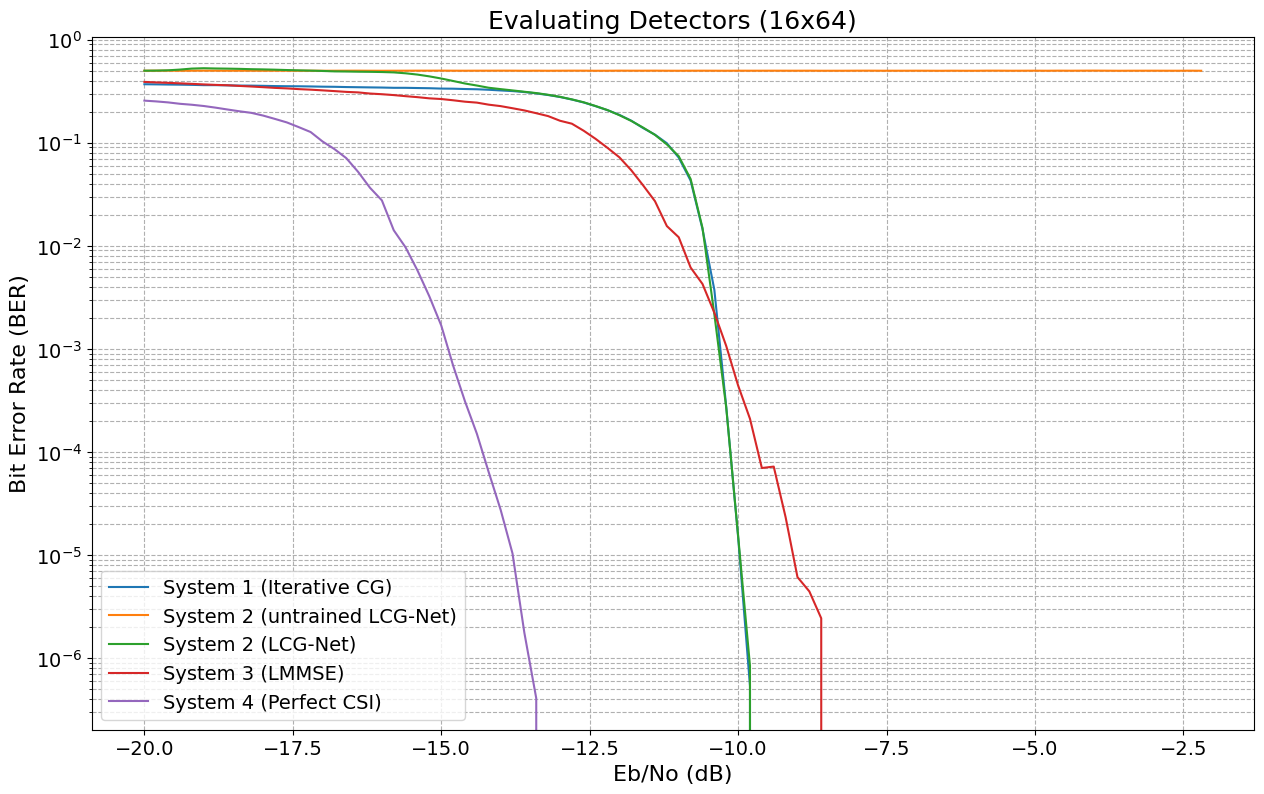

In [35]:
plt.figure(figsize=(15, 9))
plt.semilogy(ebno_dbs, SIM['CG_ber'], '-', label='System 1 (Iterative CG)')
plt.semilogy(ebno_dbs, SIM['Untrained_LCG_ber'], '-', label='System 2 (untrained LCG-Net)')
plt.semilogy(ebno_dbs, SIM['LCG_Net_ber'], '-', label='System 2 (LCG-Net)')
plt.semilogy(ebno_dbs, SIM['ls_equalizer_ber'], '-', label='System 3 (LMMSE)')
plt.semilogy(ebno_dbs, SIM['Perfect_csi_ber'], '-', label='System 4 (Perfect CSI)')
font_size= 16
plt.xlabel('Eb/No (dB)', fontsize=font_size)
plt.ylabel('Bit Error Rate (BER)', fontsize=font_size)
plt.title('Evaluating Detectors (16x64)', fontsize=font_size + 2 )
plt.xticks(fontsize=font_size - 2 )
plt.yticks(fontsize=font_size - 2 )
plt.grid(True, which='both', linestyle='--')

plt.legend(fontsize=font_size - 2)

In [33]:
ber_plots = PlotBER("Advanced Detectors")

In [34]:
# Computing and plotting BER
ber_plots.simulate(model2,
                  ebno_dbs= ebno_dbs,
                  batch_size = BATCH_SIZE,
                  num_target_block_errors=100,
                  legend="LCG Network",
                  # soft_estimates=True,
                  max_mc_iter=50,
                  show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -20.0 | 3.6078e-01 | 1.0000e+00 |      567457 |     1572864 |         1024 |        1024 |         0.1 |reached target block errors
    -19.8 | 3.5937e-01 | 1.0000e+00 |      565243 |     1572864 |         1024 |        1024 |         0.1 |reached target block errors
    -19.6 | 3.5669e-01 | 1.0000e+00 |      561029 |     1572864 |         1024 |        1024 |         0.1 |reached target block errors
    -19.4 | 3.5354e-01 | 1.0000e+00 |      556077 |     1572864 |         1024 |        1024 |         0.1 |reached target block errors
    -19.2 | 3.5101e-01 | 1.0000e+00 |      552094 |     1572864 |         1024 |        1024 |         0.1 |reached target block errors
    -19.0 | 3.4854e-01 | 1.0000e+00 |      548213 |     1572864 |

In [35]:
# Computing and plotting BER
baseline_ls = OFDMSystem(False)
ber_plots.simulate(baseline_ls,
                  ebno_dbs= ebno_dbs,
                  batch_size = BATCH_SIZE,
                  num_target_block_errors=100,
                  legend="LMMSE",
                  # soft_estimates=True,
                  max_mc_iter=50,
                  show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -20.0 | 3.8896e-01 | 1.0000e+00 |      611775 |     1572864 |         1024 |        1024 |         3.7 |reached target block errors
    -19.8 | 3.8475e-01 | 1.0000e+00 |      605154 |     1572864 |         1024 |        1024 |         0.5 |reached target block errors
    -19.6 | 3.8143e-01 | 1.0000e+00 |      599935 |     1572864 |         1024 |        1024 |         0.5 |reached target block errors
    -19.4 | 3.7755e-01 | 1.0000e+00 |      593842 |     1572864 |         1024 |        1024 |         0.5 |reached target block errors
    -19.2 | 3.7387e-01 | 1.0000e+00 |      588044 |     1572864 |         1024 |        1024 |         0.5 |reached target block errors
    -19.0 | 3.6922e-01 | 1.0000e+00 |      580740 |     1572864 |

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -20.0 | 2.5720e-01 | 1.0000e+00 |      404540 |     1572864 |         1024 |        1024 |         2.9 |reached target block errors
    -19.8 | 2.5194e-01 | 1.0000e+00 |      396264 |     1572864 |         1024 |        1024 |         0.5 |reached target block errors
    -19.6 | 2.4517e-01 | 1.0000e+00 |      385617 |     1572864 |         1024 |        1024 |         0.5 |reached target block errors
    -19.4 | 2.4021e-01 | 1.0000e+00 |      377821 |     1572864 |         1024 |        1024 |         0.5 |reached target block errors
    -19.2 | 2.3232e-01 | 1.0000e+00 |      365415 |     1572864 |         1024 |        1024 |         0.5 |reached target block errors
    -19.0 | 2.2611e-01 | 1.0000e+00 |      355646 |     1572864 |

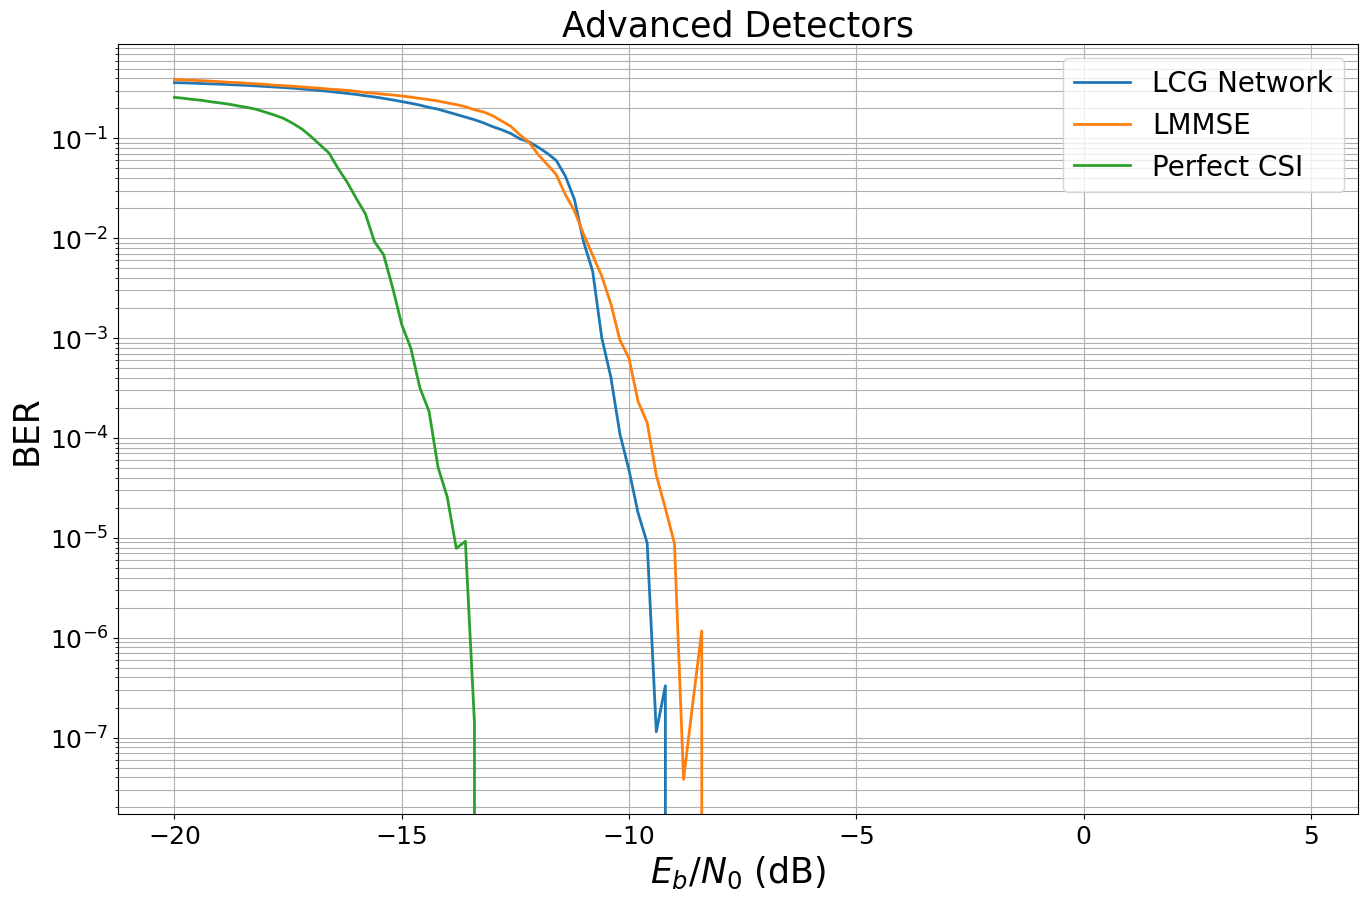

In [36]:
# Computing and plotting BER
baseline_pcsi = OFDMSystem(True)
ber_plots.simulate(baseline_pcsi,
                  ebno_dbs= ebno_dbs,
                  batch_size = BATCH_SIZE,
                  num_target_block_errors=100,
                  legend="Perfect CSI",
                  max_mc_iter=50,
                  show_fig=True);

## 7.b Training and Evaluation Workflow
- **NMSE per Layer Evaluation (Additional Analysis):**
    - `evaluate_nmse_per_layer`: This function assesses the NMSE at each layer of the `LcgNetDetector` across a spectrum of SNR values. This analysis helps in understanding the incremental NMSE reduction as the signal progresses through the network's layers.
    - `plot_nmse_per_layer`: This function generates a plot depicting the NMSE per layer, which effectively illustrates the convergence behavior of the LCG-Net's internal iterations at different SNRs. The plot, titled "NMSE per Layer at Different SNRs," confirms that increasing the number of layers generally leads to a decrease in NMSE, signifying efficient iterative refinement.

In [203]:
def evaluate_nmse_per_layer(model, snr_db_range, batch_size=BATCH_SIZE):
    all_nmse_per_snr = {}

    for ebno_db in snr_db_range:
        print(f"Evaluating at Eb/No = {ebno_db} dB")

        # Forward pass (with b passed for NMSE calculation)
        
        x_hat, no_eff, nmse_layers = model(batch_size= batch_size, ebno_db=ebno_db, nmse_vs_layer= True)
        
        all_nmse_per_snr[ebno_db] = nmse_layers

    return all_nmse_per_snr

In [204]:
def plot_nmse_per_layer(all_nmse_per_snr, sub_fig):  
    
    for snr_db, nmse_list in sorted(all_nmse_per_snr.items()):
        sub_fig.plot(nmse_list, label=f"SNR = {snr_db} dB", marker='o')

Evaluating at Eb/No = -13.0 dB
Evaluating at Eb/No = -11.0 dB
Evaluating at Eb/No = -9.0 dB
Evaluating at Eb/No = -7.0 dB
Evaluating at Eb/No = -5.0 dB
Evaluating at Eb/No = -3.0 dB
Evaluating at Eb/No = -1.0 dB
Evaluating at Eb/No = -13.0 dB
Evaluating at Eb/No = -11.0 dB
Evaluating at Eb/No = -9.0 dB
Evaluating at Eb/No = -7.0 dB
Evaluating at Eb/No = -5.0 dB
Evaluating at Eb/No = -3.0 dB
Evaluating at Eb/No = -1.0 dB


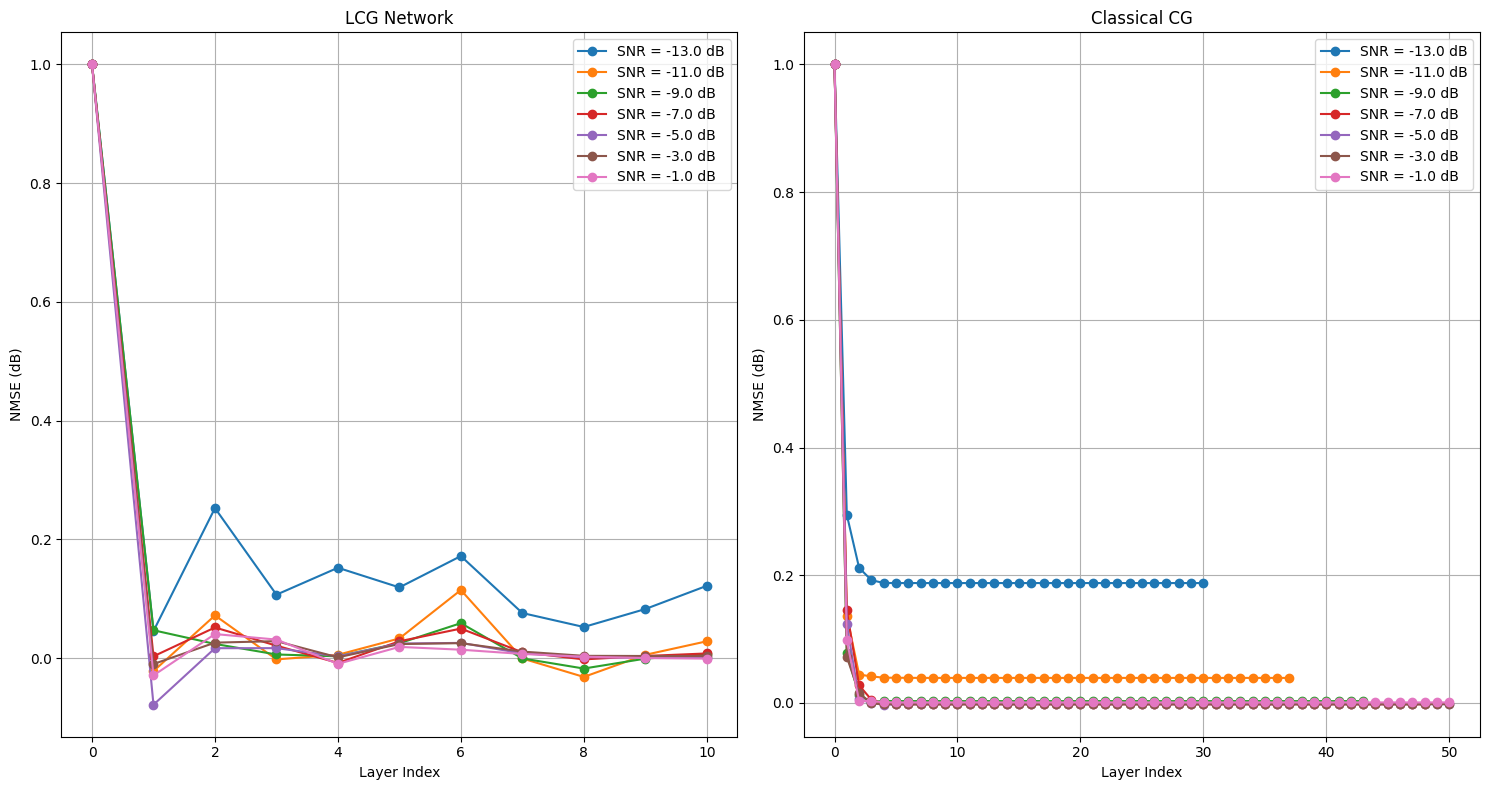

In [209]:
ebno_dbs2 = np.arange(-13.0, # Min SNR for evaluation
                     0.0, # Max SNR for evaluation
                     2)
fig, axs = plt.subplots(1, 2, figsize=(15, 8)) 

# Evaluate
all_nmse_per_snr1 = evaluate_nmse_per_layer(model2, ebno_dbs2, batch_size=BATCH_SIZE)
all_nmse_per_snr2 = evaluate_nmse_per_layer(system, ebno_dbs2, batch_size=BATCH_SIZE)

# Plot
plot_nmse_per_layer(all_nmse_per_snr1, axs[0])
axs[0].set_title("LCG Network")
axs[0].set_xlabel("Layer Index")
axs[0].set_ylabel("NMSE (dB)")
axs[0].grid(True)
axs[0].legend()

plot_nmse_per_layer(all_nmse_per_snr2, axs[1])
axs[1].set_title("Classical CG")
axs[1].set_xlabel("Layer Index")
axs[1].set_ylabel("NMSE (dB)")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

In [211]:
def plot_nmse_per_layer_independent(all_nmse_per_snr):
    plt.figure(figsize=(10, 6))
    
    for snr_db, nmse_list in sorted(all_nmse_per_snr.items()):
        plt.plot(nmse_list, label=f"SNR = {snr_db} dB", marker='o')

    plt.xlabel("Layer Index")
    plt.ylabel("NMSE (dB)")
    plt.title("NMSE per Layer at Different SNRs")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Evaluating at Eb/No = -13.0 dB
Evaluating at Eb/No = -11.0 dB
Evaluating at Eb/No = -9.0 dB
Evaluating at Eb/No = -7.0 dB
Evaluating at Eb/No = -5.0 dB
Evaluating at Eb/No = -3.0 dB
Evaluating at Eb/No = -1.0 dB


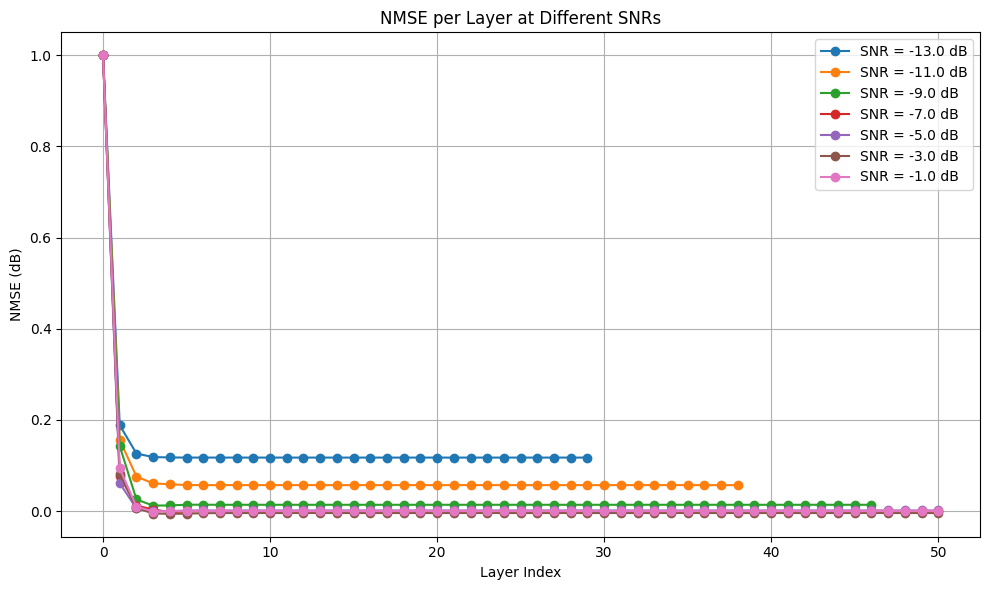

In [212]:
all_nmse_per_snr= evaluate_nmse_per_layer(system, ebno_dbs2, batch_size= BATCH_SIZE)
plot_nmse_per_layer_independent(all_nmse_per_snr)